In [1]:
import io
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa

# ignore the warning messge
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

2021-09-27 00:58:26.283679: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


# Loading seen/open dataset and unseen/closed dataset

In [2]:
import os  
import cv2
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder

# Loading np array from images
def make_dataset(labels, dir_path, IMG_SIZE = 150):
    # initial an empty list X to store image of np.array()
    X = []

    # initial an empty list Z to store labels/names of cat individauls
    Z = []
    for label in labels:
        DIR = dir_path + label
        for img in tqdm(os.listdir(DIR)):
            path = os.path.join(DIR,img)
            # reading images
            img = cv2.imread(path,cv2.IMREAD_COLOR)
            # resizing images to (150, 150, 3), 3 is the number of channels - RGB
            img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
        
            X.append(np.array(img))
            Z.append(str(label)) 
    ## Transform labels in Z to Y from class 0 to class 9, as 10 different cat individuals
    le=LabelEncoder()
    Y=le.fit_transform(Z)

    ## Transform and normalize X in the range of [0, 1]
    X=np.array(X)
    X=X/255.
    return X, Y

In [3]:
dir_path = '/kaggle/input/squirrel-monkey/Saimiri sciureus/'
IMG_SIZE = 150

# 44 monkey individuals, randomly select seen datset and unseen dataset
# make open set and unseen set 
def make_seen_unseen(num_classes, seen_ratio):
    arr = np.arange(num_classes)
    np.random.shuffle(arr)
    
    labels_seen = [str(i) for i in arr[:int(num_classes * seen_ratio)]]
    labels_unseen = [str(i) for i in arr[int(num_classes * seen_ratio):]]
    
    X_seen, Y_seen = make_dataset(labels_seen, dir_path)
    X_unseen, Y_unseen = make_dataset(labels_unseen, dir_path)
    return X_seen, Y_seen, X_unseen, Y_unseen

In [4]:
X_seen, Y_seen, X_unseen, Y_unseen = make_seen_unseen(44, 0.9)

100%|██████████| 6/6 [00:00<00:00, 171.07it/s]


# VGG 16 - Classification

In [5]:
def train_vgg16_model():
    base_model_16 = tf.keras.applications.vgg16.VGG16(include_top=False,
                      input_shape = (imsize,imsize,3),
                      weights = 'imagenet')

    # freeze all the layers of VGG, so they won't be trained.
    for layer in base_model_16.layers:
        layer.trainable = False

    model_vgg_16 = tf.keras.models.Sequential([
    base_model_16,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=1024, activation='relu'),
    tf.keras.layers.Dense(units=len(Y_seen), activation='softmax')
    ])
    model_vgg_16.compile(optimizer=tf.keras.optimizers.Adam(0.0001), loss='sparse_categorical_crossentropy', metrics=['acc']) 
    model_vgg_16.fit(x=x_train,
                     y=y_train,
                     epochs=EPOCHS,
                     batch_size=batch_size,
                     verbose=1)

    acc = round(model_vgg_16.evaluate(x_test, y_test)[1], 2)
    print('The accuracy on the Closed Dataset with VGG16 classification is {}'.format(acc))
    return model_vgg_16, acc

# Constractive Loss

In [6]:
# Helper Function 

# Create positive pairs and negative pairs
import random
def create_pairs(images, labels, numClasses = len(np.unique(Y_seen))):
    # initialize two empty lists to hold the (image, image) pairs and
    # labels to indicate if a pair is positive (0) or negative (1)
    np.random.seed(2021)
    pairImages = []
    pairLabels = []
    
    # calculate the total number of classes present in the dataset
    # and then build a list of indexes for each class label that
    # provides the indexes for all examples with a given label
    idx = [np.where(labels == i)[0] for i in range(numClasses)]
    
    # loop voer all images
    for idxA in range(len(images)):
        # grab the current image and label belonging to the current iteration
        currentImage = images[idxA]
        label = labels[idxA]
        
        # randomly pick on an image that belongs to the *same* class label
        posId = random.choice(idx[label])
        posImage = images[posId]
        
        # prepare a positive pair and update the images and labels
        pairImages.append([currentImage, posImage])
        pairLabels.append([0])
        
        # grab the indices for each of the class labels *not* equal to
        # the current label and randomly pick an image corresponding
        # to a label *not* equal to the current label
        negId = np.where(labels != label)[0]
        negIdx = random.choice(negId)
        negImage = images[negIdx]
        
        # prepare a negative pair of images and update out lists
        pairImages.append([currentImage, negImage])
        pairLabels.append([1])
    
    return (np.array(pairImages), np.array(pairLabels))



# Function to calculate the distance between two images (Euclidean Distance used here)
import tensorflow.keras.backend as K
def euclidean_distance(vectors):
    # unpack the vectors into separate lists
    (featsA, featsB) = vectors
    # compute the sum of squared distances between the vectors
    sumSquared = K.sum(K.square(featsA - featsB), axis=1,
                       keepdims=True)
    # return the euclidean distance between the vectors
    return K.sqrt(K.maximum(sumSquared, K.epsilon()))


# contrastive loss function
def contrastive_loss(y, preds, margin=1):
    # explicitly cast the true class label data type to the predicted
    # class label data type (otherwise we run the risk of having two
    # separate data types, causing TensorFlow to error out)
    y = tf.cast(y, preds.dtype)
    # calculate the contrastive loss between the true labels and
    # the predicted labels
    squaredPreds = K.square(preds)
    squaredMargin = K.square(K.maximum(margin - preds, 0))
    loss = K.mean((1 - y) * squaredPreds + y * squaredMargin)
    # return the computed contrastive loss to the calling function
    return loss


# train the model using VGG 16 base model
def train_cl_model():
    base_model_16 = tf.keras.applications.vgg16.VGG16(include_top=False,
                  input_shape = (imsize,imsize,3),
                  weights = 'imagenet')

    # freeze all the layers of VGG, so they won't be trained.
    for layer in base_model_16.layers:
        layer.trainable = False

    

    model_cl = tf.keras.models.Sequential([
        base_model_16,
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(units=1024, activation='relu'),
        tf.keras.layers.Dense(embeddingDim, activation=None), # No activation on final dense layer
        tf.keras.layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1)) # L2 normalize embeddings
    ])

    
    imgA = tf.keras.layers.Input(shape=((imsize, imsize, 3)))
    imgB = tf.keras.layers.Input(shape=((imsize, imsize, 3)))
    
    featsA = model_cl(imgA)
    featsB = model_cl(imgB)
   
    distance = tf.keras.layers.Lambda(euclidean_distance)([featsA, featsB])
    model = tf.keras.Model(inputs=[imgA, imgB], outputs=distance)
    model.compile(loss=contrastive_loss, optimizer=tf.keras.optimizers.Adam(0.001))

    model.fit([pairTrain[:, 0], pairTrain[:, 1]], labelTrain[:],
               batch_size = batch_size, 
               epochs=EPOCHS, 
               verbose=1)
    return model_cl

In [7]:
# accuracy function - contrastive loss

import pylab as plot
from sklearn.neighbors import KNeighborsClassifier
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

def acc_cl(x_test, y_test, X_unseen, Y_unseen, k = 1, d_t = 1):
    embedding_train_cl = []
    for i in range(len(y_train)):
        embedding_train_cl.append(model_cl(x_train[i].reshape(1, imsize, imsize, 3))[0])
    embedding_train_cl = np.array(embedding_train_cl, dtype=float) 

    knn_cl = KNeighborsClassifier(n_neighbors = k)
    knn_cl.fit(embedding_train_cl, y_train)
    
    #find the center point for each class in training set
    support_cl = []
    for i in range(len(np.unique(y_train))):
        support_cl.append(np.mean(embedding_train_cl[y_train==i], axis=0))
    support_cl = np.array(support_cl, dtype=float)
    
    pred = []
    temp_x = np.append(x_test, X_unseen, axis=0)
    temp_y = np.append(y_test, Y_unseen, axis=0)
    
    arr = np.arange(temp_y.shape[0])
    np.random.shuffle(arr)
    
    temp_x = temp_x[arr]
    temp_y = temp_y[arr]
    
    for i in range(len(temp_y)):
        dists = []
        for j in range(len(np.unique(y_train))):
            embedding_test = model_cl(temp_x[i].reshape(1, 150, 150, 3))
            embedding_anchor = support_cl[j]
            #dist = tf.math.l2_normalize(embedding_test - embedding_anchor, axis=-1)
            dist = np.sum((embedding_test - embedding_anchor) ** 2) ** (1/2)
            dists.append(dist)
        #a.append(dists)
        if min(dists) >= d_t:
            pred.append(10)
        else:
            pred.append(knn_cl.predict(embedding_test)[0])

    pred = np.array(pred)
    
    x_test_embedding = model_cl(x_test)
    acc_close = round(knn_cl.score(x_test_embedding, y_test), 2)
    acc_open = round(np.mean(pred == temp_y), 2)
    print('The accuracy on the Closed Dataset with contrastive loss is {}'.format(acc_close))
    print('The accuracy on the Open Dataset with contrastive lossis {}'.format(acc_open))
    
    return (acc_close, acc_open)

# Triplet Loss

In [8]:
from sklearn.neighbors import KNeighborsClassifier

## triplet loss using VGG 16 base model
imsize = 150
embeddingDim = 128
EPOCHS = 20
batch_size = 256

def train_tl_model():
    base_model_16 = tf.keras.applications.vgg16.VGG16(include_top=False,
                      input_shape = (imsize, imsize, 3),
                      weights = 'imagenet')

    # freeze all the layers of VGG, so they won't be trained.
    for layer in base_model_16.layers:
        layer.trainable = False

    model_tl = tf.keras.models.Sequential([
        base_model_16,
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(units=1024, activation='relu'),
        tf.keras.layers.Dense(embeddingDim, activation=None), # No activation on final dense layer
        tf.keras.layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1)) # L2 normalize embeddings
    ])

    model_tl.compile(
        optimizer=tf.keras.optimizers.Adam(0.001),
        loss=tfa.losses.TripletSemiHardLoss())

    model_tl.fit(x=x_train, y= y_train,
                 batch_size=batch_size,
                 epochs=EPOCHS, 
                 verbose=1)
    return model_tl

In [9]:
import pylab as plot
from sklearn.neighbors import KNeighborsClassifier
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

def acc_tl(x_test, y_test, X_unseen, Y_unseen, k = 1, d_t = 1):
    embedding_train_tl = []
    for i in range(len(y_train)):
        embedding_train_tl.append(model_tl(x_train[i].reshape(1, imsize, imsize, 3))[0])
        
    embedding_train_tl = np.array(embedding_train_tl, dtype=float) 

    knn_tl = KNeighborsClassifier(n_neighbors = k)
    knn_tl.fit(embedding_train_tl, y_train)
    
    #find the center point for each class in training set
    support_tl = []
    for i in range(len(np.unique(y_train))):
        support_tl.append(np.mean(embedding_train_tl[y_train==i], axis=0))
        
    support_tl = np.array(support_tl, dtype=float)
    
    pred = []
    temp_x = np.append(x_test, X_unseen, axis=0)
    temp_y = np.append(y_test, Y_unseen, axis=0)
    
    arr = np.arange(temp_y.shape[0])
    np.random.shuffle(arr)
    
    temp_x = temp_x[arr]
    temp_y = temp_y[arr]
    
    for i in range(len(temp_y)):
        dists = []
        for j in range(len(np.unique(y_train))):
            embedding_test = model_tl(temp_x[i].reshape(1, 150, 150, 3))
            embedding_anchor = support_tl[j]
            #dist = tf.math.l2_normalize(embedding_test - embedding_anchor, axis=-1)
            dist = np.sum((embedding_test - embedding_anchor) ** 2) ** (1/2)
            dists.append(dist)
        #a.append(dists)
        if min(dists) >= d_t:
            pred.append(10)
        else:
            pred.append(knn_tl.predict(embedding_test)[0])

    pred = np.array(pred)
    
    x_test_embedding = model_tl(x_test)
    acc_close = round(knn_tl.score(x_test_embedding, y_test), 2)
    acc_open = round(np.mean(pred == temp_y), 2)
    print('The accuracy on the Closed Dataset with triplet loss is {}'.format(acc_close))
    print('The accuracy on the Open Dataset with triplet lossis {}'.format(acc_open))
    
    return (acc_close, acc_open)

# Configuration setting

In [10]:
imsize = 150
batch_size = 256
EPOCHS = 20
embeddingDim = 128

# 10 folds cross validation

In [11]:
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=10, random_state=2021, shuffle=True)

acc_vgg16 = []
acc_cl_close = []
acc_cl_open = []
acc_tl_close = []
acc_tl_open = []

for train_index, test_index in skf.split(X_seen, Y_seen):
    x_train,x_test,y_train,y_test = X_seen[train_index], X_seen[test_index], Y_seen[train_index], Y_seen[test_index]
    model_vgg16, acc = train_vgg16_model()
    acc_vgg16.append(acc)
    
    (pairTrain, labelTrain) = create_pairs(x_train, y_train)
    model_cl = train_cl_model()
    (close_cl, open_cl) = acc_cl(x_test, y_test, X_unseen, Y_unseen)
    acc_cl_close.append(close_cl)
    acc_cl_open.append(open_cl)

    model_tl = train_tl_model()
    (close_tl, open_tl) = acc_tl(x_test, y_test, X_unseen, Y_unseen)
    acc_tl_close.append(close_tl)
    acc_tl_open.append(open_tl)

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)
2021-09-27 00:58:36.147825: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-09-27 00:58:36.151270: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-09-27 00:58:36.189679: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-09-27 00:58:36.190298: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla P100-PCIE-16GB computeCapability: 6.0
coreClock: 1.3285GHz coreCount: 56 deviceMemorySize: 15.90GiB deviceMemoryBandwidth: 681.88

58892288/58889256 [==============================] - 1s 0us/step


2021-09-27 00:58:40.270275: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-09-27 00:58:40.280567: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2000179999 Hz


Epoch 1/20


2021-09-27 00:58:40.906828: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2021-09-27 00:58:41.954213: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11
2021-09-27 00:58:41.992767: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.8


1/1 [==============================] - 14s 14s/step - loss: 5.5521 - acc: 0.0000e+00
Epoch 2/20
1/1 [==============================] - 0s 204ms/step - loss: 4.9694 - acc: 0.0707
Epoch 3/20
1/1 [==============================] - 0s 203ms/step - loss: 4.4493 - acc: 0.1515
Epoch 4/20
1/1 [==============================] - 0s 204ms/step - loss: 3.9941 - acc: 0.2525
Epoch 5/20
1/1 [==============================] - 0s 203ms/step - loss: 3.6010 - acc: 0.3737
Epoch 6/20
1/1 [==============================] - 0s 185ms/step - loss: 3.2642 - acc: 0.4545
Epoch 7/20
1/1 [==============================] - 0s 206ms/step - loss: 2.9753 - acc: 0.5152
Epoch 8/20
1/1 [==============================] - 0s 203ms/step - loss: 2.7254 - acc: 0.5404
Epoch 9/20
1/1 [==============================] - 0s 203ms/step - loss: 2.5035 - acc: 0.5657
Epoch 10/20
1/1 [==============================] - 0s 191ms/step - loss: 2.3030 - acc: 0.5960
Epoch 11/20
1/1 [==============================] - 0s 192ms/step - loss: 2.11

/opt/conda/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/conda/lib/python3.7/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


The accuracy on the Closed Dataset with contrastive loss is 0.82
The accuracy on the Open Dataset with contrastive lossis 0.35
Epoch 1/20
1/1 [==============================] - 1s 830ms/step - loss: 0.9786
Epoch 2/20
1/1 [==============================] - 0s 192ms/step - loss: 0.9149
Epoch 3/20
1/1 [==============================] - 0s 208ms/step - loss: 0.7698
Epoch 4/20
1/1 [==============================] - 0s 193ms/step - loss: 0.7171
Epoch 5/20
1/1 [==============================] - 0s 189ms/step - loss: 0.5773
Epoch 6/20
1/1 [==============================] - 0s 192ms/step - loss: 0.4671
Epoch 7/20
1/1 [==============================] - 0s 198ms/step - loss: 0.3899
Epoch 8/20
1/1 [==============================] - 0s 188ms/step - loss: 0.3084
Epoch 9/20
1/1 [==============================] - 0s 206ms/step - loss: 0.2780
Epoch 10/20
1/1 [==============================] - 0s 206ms/step - loss: 0.2333
Epoch 11/20
1/1 [==============================] - 0s 218ms/step - loss: 0.1885
Ep

/opt/conda/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/conda/lib/python3.7/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


The accuracy on the Closed Dataset with triplet loss is 0.86
The accuracy on the Open Dataset with triplet lossis 0.35
Epoch 1/20
1/1 [==============================] - 1s 752ms/step - loss: 5.6769 - acc: 0.0000e+00
Epoch 2/20
1/1 [==============================] - 0s 206ms/step - loss: 5.1076 - acc: 0.0152
Epoch 3/20
1/1 [==============================] - 0s 191ms/step - loss: 4.6021 - acc: 0.1566
Epoch 4/20
1/1 [==============================] - 0s 202ms/step - loss: 4.1625 - acc: 0.2020
Epoch 5/20
1/1 [==============================] - 0s 204ms/step - loss: 3.7840 - acc: 0.2222
Epoch 6/20
1/1 [==============================] - 0s 191ms/step - loss: 3.4568 - acc: 0.2929
Epoch 7/20
1/1 [==============================] - 0s 206ms/step - loss: 3.1660 - acc: 0.3434
Epoch 8/20
1/1 [==============================] - 0s 192ms/step - loss: 2.9050 - acc: 0.4646
Epoch 9/20
1/1 [==============================] - 0s 185ms/step - loss: 2.6709 - acc: 0.5303
Epoch 10/20
1/1 [=======================

# Average accuracy from 10 folds CV

In [12]:
avg_0 = round(np.mean(acc_vgg16), 2)
print('average accuracy for vgg16 classification on closed dataset: {}'.format(avg_0)) 

average accuracy for vgg16 classification on closed dataset: 0.6


In [13]:
avg_1 = round(np.mean(acc_cl_close), 2)
print('average accuracy for contrastive loss on closed dataset: {}'.format(avg_1)) 

average accuracy for contrastive loss on closed dataset: 0.67


In [14]:
avg_2 = round(np.mean(acc_cl_open), 2)
print('average accuracy for contrastive loss on open dataset: {}'.format(avg_2)) 

average accuracy for contrastive loss on open dataset: 0.29


In [15]:
avg_3 = round(np.mean(acc_tl_close), 2)
print('average accuracy for triplet loss on closed dataset: {}'.format(avg_3)) 

average accuracy for triplet loss on closed dataset: 0.76


In [16]:
avg_4 = round(np.mean(acc_tl_open), 2)
print('average accuracy for triplet loss on open dataset: {}'.format(avg_4)) 

average accuracy for triplet loss on open dataset: 0.32


# Plot of accuracy of VGG16 classification, contrastive loss and triplet loss on Closed data and Open dataset

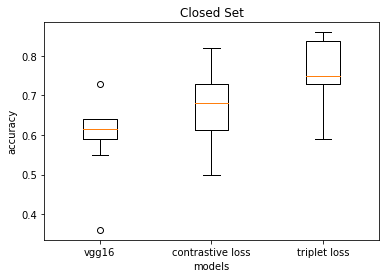

In [17]:
plt.boxplot([acc_vgg16, acc_cl_close, acc_tl_close], labels=['vgg16', 'contrastive loss', 'triplet loss'])
plt.xlabel('models')
plt.ylabel('accuracy')
plt.title('Closed Set')
plt.show()

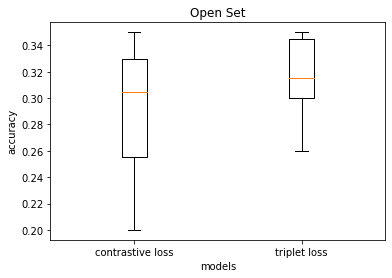

In [18]:
plt.boxplot([acc_cl_open, acc_tl_open], labels=['contrastive loss', 'triplet loss'])
plt.xlabel('models')
plt.ylabel('accuracy')
plt.title('Open Set')
plt.show()